## Dataset Exploration

In [7]:
import os 
#make sure your working directory is the repository root. 
if not os.getcwd().endswith("idp-radio-1"):
    os.chdir("../../")
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from src.preprocessing.rescaling import scaler

In [8]:
load_dotenv(find_dotenv())
chexpert_folder = Path(os.environ.get("CHEXPERT_DATASET_DIRECTORY"))

In [9]:
train_labels = pd.read_csv(chexpert_folder / "train.csv")
valid_labels = pd.read_csv(chexpert_folder / "valid.csv")
valid_labels.head()

,Unnamed: 0,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,patient_id
0,0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64541
1,1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,64542
2,2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,64542
3,3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64543
4,4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64544


First, we have a simple look at the pictures in the dataset. There are two kinds of views, lateral
and frontal. 

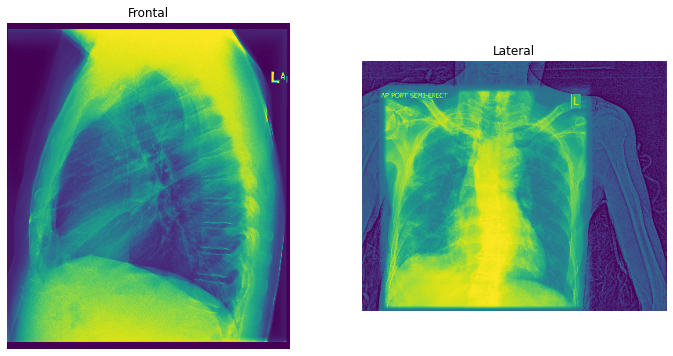

In [136]:
# image saved as numpy array
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].set_title('Frontal')
axs[0].axis('off')
frontal = mpimg.imread(chexpert_folder + valid_labels.loc[2]["Path"])
axs[0].imshow(frontal)
axs[1].set_title('Lateral')
axs[1].axis('off')
lateral = mpimg.imread(chexpert_folder + valid_labels.loc[3]["Path"])
axs[1].imshow(lateral)
plt.show()

In [45]:
print('# of lateral view pictures in valid:', len(valid_labels[valid_labels["Frontal/Lateral"] == "Lateral"]))
print('# of frontal view pictures in valid:', len(valid_labels[valid_labels["Frontal/Lateral"] == "Frontal"]))
print('# of lateral view pictures in train:', len(train_labels[train_labels["Frontal/Lateral"] == "Lateral"]))
print('# of frontal view pictures in train:', len(train_labels[train_labels["Frontal/Lateral"] == "Frontal"]))

# of lateral view pictures in valid: 32
# of frontal view pictures in valid: 202
# of lateral view pictures in train: 32387
# of frontal view pictures in train: 191027


We load the pictures into a numpy array so we can later calculate mean images, do color analysis, etc.

In [44]:
valid_lateral_list = [mpimg.imread(chexpert_folder+sample_path) for sample_path in valid_labels[valid_labels["Frontal/Lateral"] == "Lateral"]["Path"]]
valid_frontal_list = [mpimg.imread(chexpert_folder+sample_path) for sample_path in valid_labels[valid_labels["Frontal/Lateral"] == "Frontal"]["Path"]]

# When using the full dataset, loading all images takes a lot of time and requires at least 10 GB of RAM
#train_lateral_list = [mpimg.imread(chexpert_folder+sample_path) for sample_path in train_labels[train_labels["Frontal/Lateral"] == "Lateral"]["Path"]]
#train_frontal_list = [mpimg.imread(chexpert_folder+sample_path) for sample_path in train_labels[train_labels["Frontal/Lateral"] == "Frontal"]["Path"]]

The pictures in the dataset are of varying size, so we take a look at the dimensions of the images. This information needs to be
considered when preprocessing the dataset.

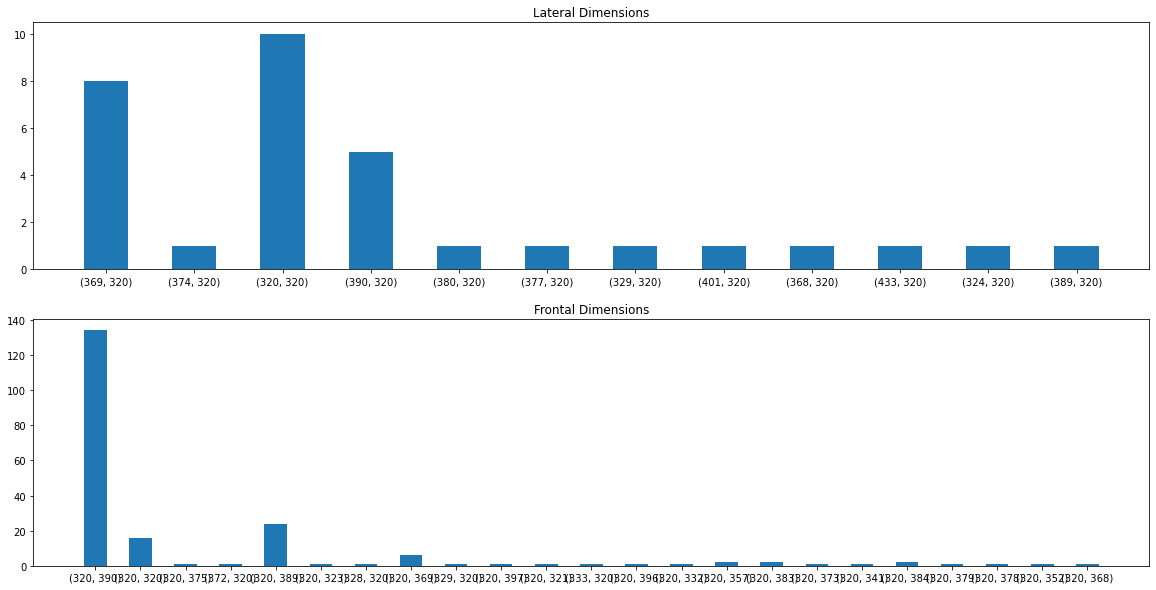

In [67]:
# Prints all the different dimensions that images have
frontal_dimensions = {}
for img in frontal_list:
    dim = str((len(img), len(img[0])))
    if dim not in frontal_dimensions.keys():
        frontal_dimensions[dim] = 1
    else:
        frontal_dimensions[dim] += 1
        
        
lateral_dimensions = {}
for img in lateral_list:
    dim = str((len(img), len(img[0])))
    if dim not in lateral_dimensions.keys():
        lateral_dimensions[dim] = 1
    else:
        lateral_dimensions[dim] += 1

fig, axs = plt.subplots(nrows=2, figsize = (20,10))
axs[0].set_title('Lateral Dimensions')
axs[0].bar(list(lateral_dimensions.keys()), list(lateral_dimensions.values()), 0.5)
axs[1].set_title('Frontal Dimensions')
axs[1].bar(list(frontal_dimensions.keys()), list(frontal_dimensions.values()), 0.5)
plt.show()

['(320, 375)',
 '(372, 320)',
 '(320, 323)',
 '(328, 320)',
 '(329, 320)',
 '(320, 397)',
 '(320, 321)',
 '(333, 320)',
 '(320, 396)',
 '(320, 332)',
 '(320, 373)',
 '(320, 341)',
 '(320, 379)',
 '(320, 378)',
 '(320, 352)',
 '(320, 368)']

We scale all input images to the same size (512x512) using interpolation and calculate a 
mean image over all input images to get an intuition of what the data looks like.

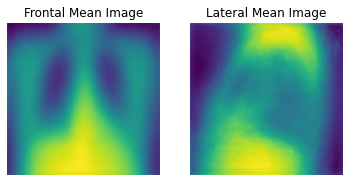

In [37]:
frontal_resized = [scaler.Scaler(img, 512).resize('LINEAR') for img in frontal_list]
lateral_resized = [scaler.Scaler(img, 512).resize('LINEAR') for img in lateral_list]
mean_frontal = np.zeros((512, 512), np.float)
mean_lateral = np.zeros((512, 512), np.float)

for img in lateral_resized:
    mean_lateral = mean_lateral + img /len(lateral_resized)
for img in frontal_resized:
    mean_frontal = mean_frontal + img /len(frontal_resized)

fig, axs = plt.subplots(ncols=2)
axs[0].set_title('Frontal Mean Image')
axs[0].axis('off')
axs[0].imshow(mean_frontal)
axs[1].set_title('Lateral Mean Image')
axs[1].axis('off')
axs[1].imshow(mean_lateral)
plt.show()

In addition to the images, we have patient-related features and picture metadata in the dataset.

In [39]:
column_names = np.array(labels.columns)
print('Patient Information: ', column_names[2:4])
print('Metadata: ', column_names[4:6])

Patient Information:  ['Age' 'Frontal/Lateral']
Metadata:  ['AP/PA' 'No Finding']


As seen previously, there are two different views: frontal and lateral.

In [35]:
combined, num_frontal, num_lateral = 0, 0, 0
patients = os.listdir(chexpert_folder + 'train')
for patient in patients:
    studies = os.listdir(os.path.join(chexpert_folder + 'train', patient))
    for study in studies:
        views = os.listdir(os.path.join(chexpert_folder + 'train', patient, study))
        if len(views) > 1 :
            combined += 1
        else: 
            if 'lateral' in views[0]:
                num_lateral += 1
            else:
                num_frontal += 1
print('# of studies with both frontal and lateral images: ', combined)
print('# of studies with only a frontal image: ', num_frontal)
print('# of studies with only a lateral image: ', num_lateral)

# of studies with both frontal and lateral images:  3340
# of studies with only a frontal image:  15607
# of studies with only a lateral image:  3


Next, we want to get an intuition about how the images are distributed across patients.

In [36]:
num_studies = [['1', 0], ['2', 0], ['3', 0], ['4', 0], ['5 or more', 0]]
patients = os.listdir(chexpert_folder + 'train')
for patient in patients:
    studies = os.listdir(os.path.join(chexpert_folder + 'train', patient))
    if len(studies) >= 5:
        num_studies[4][1] += 1
    else:
        num_studies[len(studies)-1][1] += 1
for x in num_studies:
    print('# of patients with', x[0] , 'studies: ', x[1])

# of patients with 1 studies:  3329
# of patients with 2 studies:  1097
# of patients with 3 studies:  589
# of patients with 4 studies:  358
# of patients with 5 or more studies:  1027


Lastly, we have a look at the diseases and their distribution in the dataset. <br>
Attention! Encoding for labels: <br>
blank for unmentioned, 0 for negative, -1 for uncertain, and 1 for positive

In [37]:
data = pd.read_csv(dataset_folder + 'valid.csv')
labels = np.array(targets.columns[6:20])
data = data[labels].abs()
for label in labels:
    print('The pathology', label, 'is present in', round(data[label].sum()/data[label].size*100, 2), '% of the images')

The pathology No Finding is present in 16.24 % of the images
The pathology Enlarged Cardiomediastinum is present in 46.58 % of the images
The pathology Cardiomegaly is present in 29.06 % of the images
The pathology Lung Opacity is present in 53.85 % of the images
The pathology Lung Lesion is present in 0.43 % of the images
The pathology Edema is present in 19.23 % of the images
The pathology Consolidation is present in 14.1 % of the images
The pathology Pneumonia is present in 3.42 % of the images
The pathology Atelectasis is present in 34.19 % of the images
The pathology Pneumothorax is present in 3.42 % of the images
The pathology Pleural Effusion is present in 28.63 % of the images
The pathology Pleural Other is present in 0.43 % of the images
The pathology Fracture is present in 0.0 % of the images
The pathology Support Devices is present in 45.73 % of the images
